# Finding Amenity Clusters 

### Author(s): [Ben Dykstra](https://github.com/bfdykstra)
### Date:  June, 2017
### Tags: #Data-science, #machine-learning, #amenity-clustering, #agglomerated-clustering

***
###	TLDR:
The purpose of this notebook is to try and find amenities that occur together.
***

### Motivation

We want to find apartment amenities that occur together a lot. We care about this because we can use these clusters to tell customers that if they have certain groups of amenities, they will probably perform well. 

All of the algorithms here are bottom up and greedy. This means that the algorithm starts with all amenities as their own cluster and merges according to an algorithm that uses a distance metric such as euclidean distance or jaccard distance. 

More work will be done that utilizes a top down approach.

Get the data. We use customer performance data from May 2016

In [2]:
from sklearn.cluster import FeatureAgglomeration, AffinityPropagation, AgglomerativeClustering
from sklearn.metrics import jaccard_similarity_score
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform, jaccard, dice, euclidean
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import numpy as np
import seaborn as sns
np.set_printoptions(precision=5, suppress=True)
%matplotlib inline
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

sites = pd.read_csv("/Users/benjamin.dykstra/Documents/hot_prospects/data/customer_data/"
                   "CustomerPerformanceProfile_201605.csv")
sites.head()



,MMM-YYYY,Period,Property_Name,City_State,EOM_Package_Level,Products,LEADS,Air_Conditioning,Alarm_System,All_Dogs_Allowed,Broadband_Internet_Access,Business_Center_Onsite,Cable_or_Satellite,Cats_Allowed,Ceiling_Fan,Club_House,Controlled_Access,Covered_Lot,Disability_Access,Dishwasher,Door Attendant,Elevator,Extra_Storage,Fireplace,Fitness_Center,Furnished_Available,Garages,Golf Course,Google Fiber,Hablamos_Espanol,Hardwood_Floor,Large Dogs,Laundry_Facility,Microwave,Patio_or_Balcony,Pets_Allowed,Playground,Pool,Public_Transportation,Short_Term_Lease,Small_Dogs_Allowed,Spa,Tennis_Court,Utilities_Included,Verizon_FiOS,View,Vintage Building,Walk_In_Closets,Washer_Dryer_Hookup,Washer_Dryer_In_Unit,Site_Id,Address_Line_1,Metro,Zip_Code,Digital_LEADS,Print_LEADS,Guest_Cards,Phone_Calls,Desktop_Mobile_Guest_Cards,Mapped_In_Billing,Service_Billing_Amount,Total_Cost_Per_LEAD,Studio_Price,1_Bed_Price,2_Bed_Price,3_Bed_Price,4+_Bed_Price,Accepts_Credit_Card_Payments,Accepts_Electronic_Payments,ATT_Uverse,Luxury_Amenities,Smoke_Free_Community,Wireless_Internet_Access,Property_Management_Company,Community_Price
0,May-2016,201605,Twin Creeks (Antioch),"Antioch, CA",Premier Plus,"3D_FloorPlan, Community Theater, Featured Prop...",521.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1000001,1111 James Donlon Blvd,San Francisco Bay,94509,510.0,11.0,335.0,186.0,313.0,1.0,887.956667,1.704331,NaN,1488.096774,1766.612903,NaN,NaN,1.0,1.0,0.0,1.0,0.0,1.0,FPI Management,1627.354839
1,May-2016,201605,Mediterranean Village,"Fairfield, CA",Basic,*No Enhancements,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1000003,2751 Peppertree Drive,San Francisco Bay,94533,1.0,NaN,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Norman Jacobson Management Co.,NaN
2,May-2016,201605,Hillcrest,"Hayward, CA",Basic,*No Enhancements,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1000004,26790 Hayward Blvd,San Francisco Bay,94542,2.0,NaN,0.0,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,000 No PMC,NaN
3,May-2016,201605,Driftwood Apartments,"Tracy, CA",eSolution,3D_FloorPlan,133.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1000005,800 W Grantline Rd,Sacramento,95376,133.0,NaN,88.0,45.0,70.0,1.0,267.666667,2.012531,NaN,1455.129032,1786.870968,2091.451613,NaN,0.0,0.0,0.0,1.0,0.0,0.0,"JCM Partners, LLC",1777.817204
4,May-2016,201605,Sundance,"Vallejo, CA",Premier Plus,"3D_FloorPlan, Community Theater, Featured Prop...",91.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1000006,60 Rotary Way,San Francisco Bay,94591,76.0,15.0,68.0,23.0,61.0,1.0,880.550000,9.676374,NaN,1412.000000,1562.000000,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,FPI Management,1487.000000


In [3]:
# Define features that we care about. This is a complete list of all amenities listed in the data
features = ['Air_Conditioning','Alarm_System', 'All_Dogs_Allowed',
    'Broadband_Internet_Access','Business_Center_Onsite', 
    'Cable_or_Satellite', 'Cats_Allowed','Ceiling_Fan',
    'Club_House', 'Controlled_Access', 'Covered_Lot',
    'Disability_Access', 'Dishwasher', 'Door Attendant', 
    'Elevator','Extra_Storage', 'Fireplace', 'Fitness_Center',
    'Furnished_Available', 'Garages', 'Golf Course', 'Google Fiber',
    'Hablamos_Espanol', 'Hardwood_Floor', 'Large Dogs',
    'Laundry_Facility', 'Microwave', 'Patio_or_Balcony', 'Pets_Allowed',
    'Playground', 'Pool', 'Public_Transportation', 'Short_Term_Lease',
    'Small_Dogs_Allowed', 'Spa', 'Tennis_Court', 'Utilities_Included',
    'Verizon_FiOS', 'View', 'Vintage Building', 'Walk_In_Closets',
    'Washer_Dryer_Hookup', 'Washer_Dryer_In_Unit',
    'Accepts_Credit_Card_Payments', 'Accepts_Electronic_Payments',
    'ATT_Uverse', 'Luxury_Amenities', 'Smoke_Free_Community',
    'Wireless_Internet_Access']

Lets explore how the amenities are distributed and which ones occur with the most frequency

In [4]:

x = sites[features]
sums = x.sum()
sums_rel = sums/x.shape[0] #the percentage that they occur in the whole data set


#### The top ten most common amenities, thank god air conditioning is one of them.

In [5]:
sums_rel.sort_values()[39:49] 

Large Dogs            0.666781
Cable_or_Satellite    0.666831
Walk_In_Closets       0.692028
Pool                  0.707677
Pets_Allowed          0.712549
Small_Dogs_Allowed    0.725787
Patio_or_Balcony      0.788681
Cats_Allowed          0.793848
Dishwasher            0.847096
Air_Conditioning      0.870915
dtype: float64

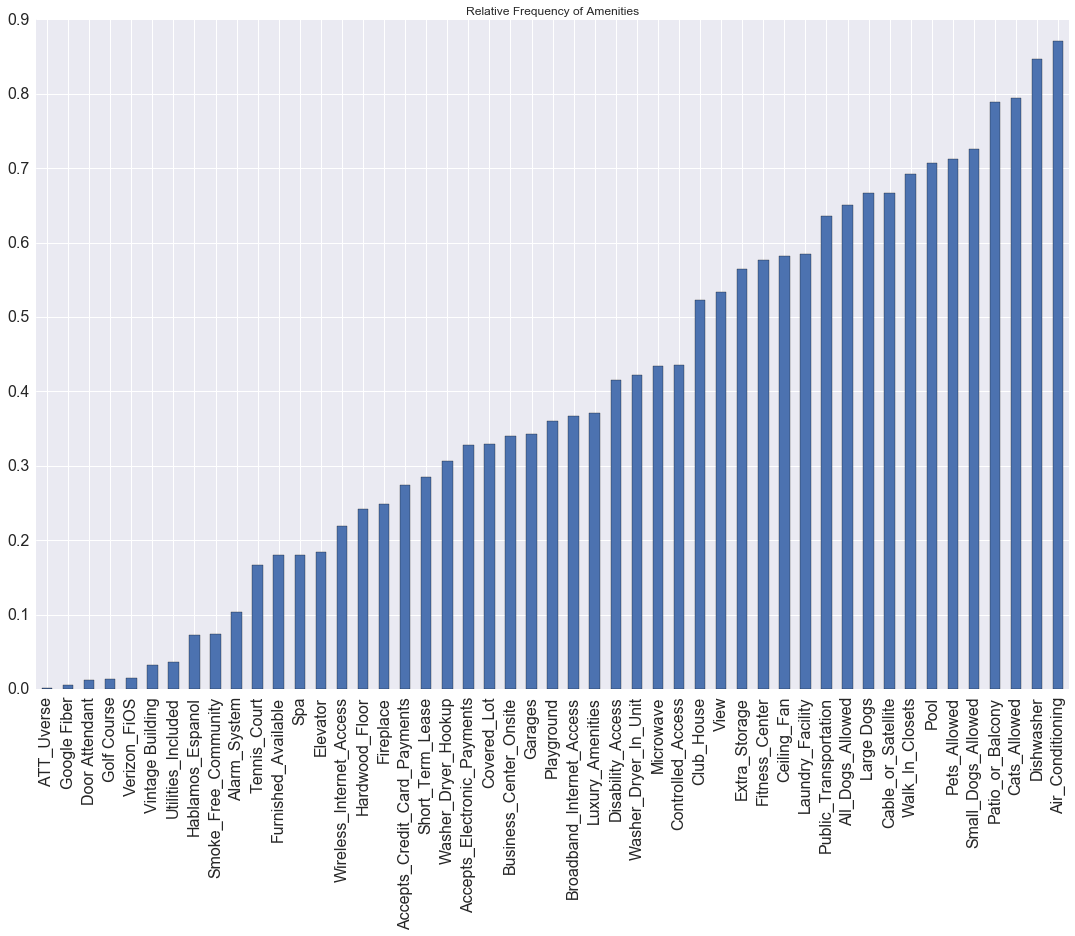

In [6]:
sums_rel.sort_values().plot(kind = 'bar', figsize = (18.5,12), 
                            title = 'Relative Frequency of Amenities', fontsize = 16);

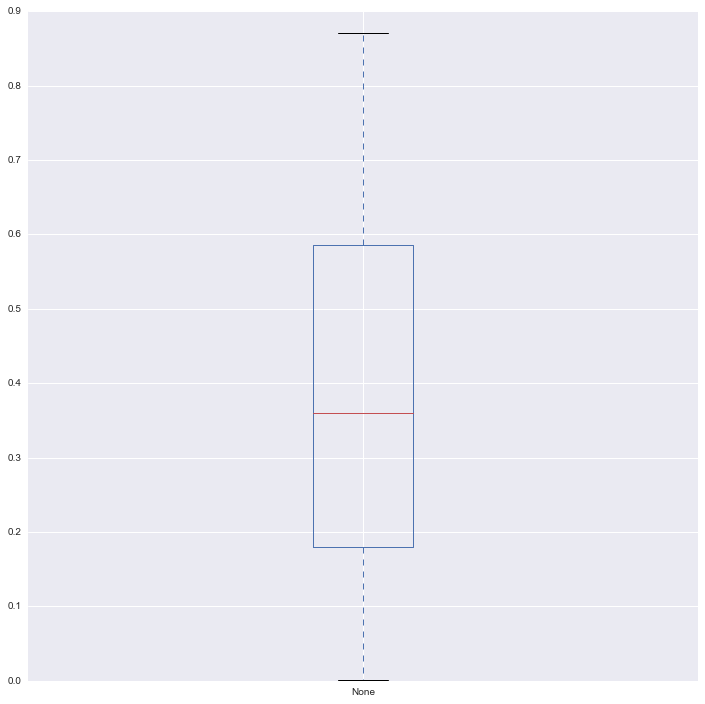

In [7]:
sums_rel.plot(kind = 'box', figsize = (12,12) );

Technically, theres no outliers (1.5 x iqr), however a look at the above histogram still shows that door attendants are present in less than 5 % of our data. Something important to remember is that just because a feature is not very common does not mean that it is not important or a draw for potential customers. In fact, it may be the opposite. In our models with Random Forests (more to come on that) spanish speaking communities were ranked as very important, even thought they are not common at all.

In [8]:
#The inter quartile range
iqr = sums.quantile(q = 0.75) - sums.quantile(q = 0.25)
print "The inter quartile range: ", iqr
print "The max: ", sums.max()
print "The min: ", sums.min()

The inter quartile range:  8227.0
The max:  17697.0
The min:  24.0


### Clustering using SKlearn packages only

In [9]:
fa_x = sites[features]

fa_x = fa_x.fillna(value = 0)
fa_x[features] = fa_x[features].astype(int) #cast all the data to ints, before they were floats
print fa_x.shape
#drop rows that dont have any information
fa_x['row_sum'] = fa_x.sum(axis = 1)
fa_x = fa_x[fa_x['row_sum'] != 0]
fa_x = fa_x[features]
print fa_x.shape

(20320, 49)
(19984, 49)


With sklearn, the clustering packages are a little tricky and don't really offer much in the way of customizing how to compute the distance (affinity) between features. So, for comparisons sake we used simple euclidean distance and ward's algorithm. 

Ward's algorithm is pretty cool in that it attempts to minimize intra-cluster variance. At each level of recursion, it only adds the cluster that adds the least variance to the cluster. However, using euclidean distance on binary data is.... not the best idea (the distance is either 1 or 0, ya feel?). It just counts the number of differences between each column and chooses the one with the smallest number of differences. Not the most sophisticated, but despite this the results make a lot of intuitive sense.

For you nerds reading this check out the wiki on ward's: https://en.wikipedia.org/wiki/Ward%27s_method

In [10]:
# Agglomerate features.
# Similar to AgglomerativeClustering, but recursively merges FEATURES instead of samples.

n = 7
agglo = FeatureAgglomeration(affinity = 'euclidean', n_clusters=n, linkage = 'ward');
agglo.fit(fa_x)

groups = {i:[] for i in range(n)}

for i, val in enumerate(agglo.labels_):
    groups[val].append(features[i])
    
for group in groups:
    print
    print "Group " + str(group) + ": ", groups[group]



Group 0:  ['Covered_Lot', 'Elevator', 'Fireplace', 'Furnished_Available', 'Hardwood_Floor', 'Playground', 'Short_Term_Lease', 'Spa', 'Tennis_Court', 'Washer_Dryer_Hookup', 'Accepts_Credit_Card_Payments', 'Accepts_Electronic_Payments', 'Wireless_Internet_Access']

Group 1:  ['Business_Center_Onsite', 'Club_House', 'Fitness_Center', 'Garages', 'Microwave', 'Washer_Dryer_In_Unit', 'Luxury_Amenities']

Group 2:  ['Broadband_Internet_Access', 'Ceiling_Fan', 'Controlled_Access', 'Disability_Access', 'Extra_Storage', 'View']

Group 3:  ['Air_Conditioning', 'Dishwasher', 'Patio_or_Balcony', 'Pool', 'Walk_In_Closets']

Group 4:  ['Alarm_System', 'Door Attendant', 'Golf Course', 'Google Fiber', 'Hablamos_Espanol', 'Utilities_Included', 'Verizon_FiOS', 'Vintage Building', 'ATT_Uverse', 'Smoke_Free_Community']

Group 5:  ['All_Dogs_Allowed', 'Cats_Allowed', 'Large Dogs', 'Pets_Allowed', 'Small_Dogs_Allowed']

Group 6:  ['Cable_or_Satellite', 'Laundry_Facility', 'Public_Transportation']


A couple of things:

1. All the dogs and cats are grouped together. They have like a 98% correlation with each other so this is good. (Group 5)
2. Air Conditioning, Dishwashers, Patio/Balcony, Pool, and Walk-in closets are all grouped together. They are all in the top ten most frequent amenities. Looks like they often occur together as well. (Group 3)
3. Credit Card payments and Electronic Payments also occur together. This also makes sense (Group 0)

Something that I think may also be happening is that amenities that just don't occur that often (Group 4) are also clustered together because they have the most aggreement in their occurences. As stated before, rare != not important. Something to keep in mind.

## using scipy now instead of sklearn

Scipy is cool because it has a lot more knobs to twist and allows you to calculate your own distance matrix and input that instead of it being calculated for you. The advantage of this is that we can now use distance metrics that are suitable for binary data. The first one that we use is the [Jaccard distance](https://en.wikipedia.org/wiki/Jaccard_index). It is a measure of dissimilarity so a value of 0 indicates that two features are very similar to each other.

In [11]:
#Computes the dissimilarity jaccard matrix
def jaccard_scipy(x):
    n_features = x.shape[1]
    sim_matr = np.zeros((n_features,n_features))
    for i in range(n_features):
        for j in range(n_features):
            sim_matr[i][j] = jaccard(x.iloc[:,i], x.iloc[:,j])
    return sim_matr


In [12]:
#Computes the dissimilarity dice matrix
def dice_scipy(x):
    n_features = x.shape[1]
    sim_matr = np.zeros((n_features,n_features))
    for i in range(n_features):
        for j in range(n_features):
            sim_matr[i][j] = dice(x.iloc[:,i], x.iloc[:,j])
    return sim_matr

In [52]:
def euclid_scipy(x):
    n_features = x.shape[1]
    sim_matr = np.zeros((n_features,n_features))
    for i in range(n_features):
        for j in range(n_features):
            sim_matr[i][j] = euclidean(x.iloc[:,i], x.iloc[:,j])
    return sim_matr

In [51]:
#gives a cut tree from a specified number of clusters and the clustering object
def gen_cut_groups(n_clusters, the_clustering):
    n = n_clusters
    cutTree = hierarchy.cut_tree(the_clustering, n_clusters = n)

    groups = {i:[] for i in range(n)}

    for i, val in enumerate(cutTree):
        groups[val[0]].append(features[i])

    for group in groups:
        print
        print "Group " + str(group) + ": ", groups[group]

In [91]:
def get_flattened(clustering, cutoff, criter, feature_list):
    flat = fcluster(clustering, t = cutoff, criterion = criter)

    groups = {i:[] for i in range(1,len(np.unique(flat)) + 1)}

    for i, val in enumerate(flat):
        groups[val].append(feature_list[i])

    for group in groups:
        print "Group " + str(group) + ": ", groups[group]
        print

In [42]:
# generate the linkage matrix
my_jac_matr = jaccard_scipy(fa_x)

# # compresses the 2-dimensional square matrix into a
# # 1-dimensional vector storing only the upper diagonal of the matrix - its symmetric along the diagonal so its chill
jac_sqrfrm = squareform(my_jac_matr)

UPGMA (Unweighted Pair Group Method with Arithmetic Mean) is a simple agglomerative (bottom-up) hierarchical clustering method. The method is generally attributed to Sokal and Michener.

The UPGMA algorithm constructs a rooted tree (dendrogram) that reflects the structure present in a pairwise similarity matrix (or a dissimilarity matrix). At each step, the nearest two clusters are combined into a higher-level cluster. The distance between any two clusters A and B, each of size (i.e., cardinality) |A| and |B| , is taken to be the average of all distances d(x,y) between pairs of objects x  in A  and y  in B, that is, the mean distance between elements of each cluster:

check this link out for more info: https://en.wikipedia.org/wiki/UPGMA

In [14]:
clustering = hierarchy.linkage(jac_sqrfrm, method = 'average') #nested list that shows the order in which clusters are merged
# eg. features[2] == small dogs

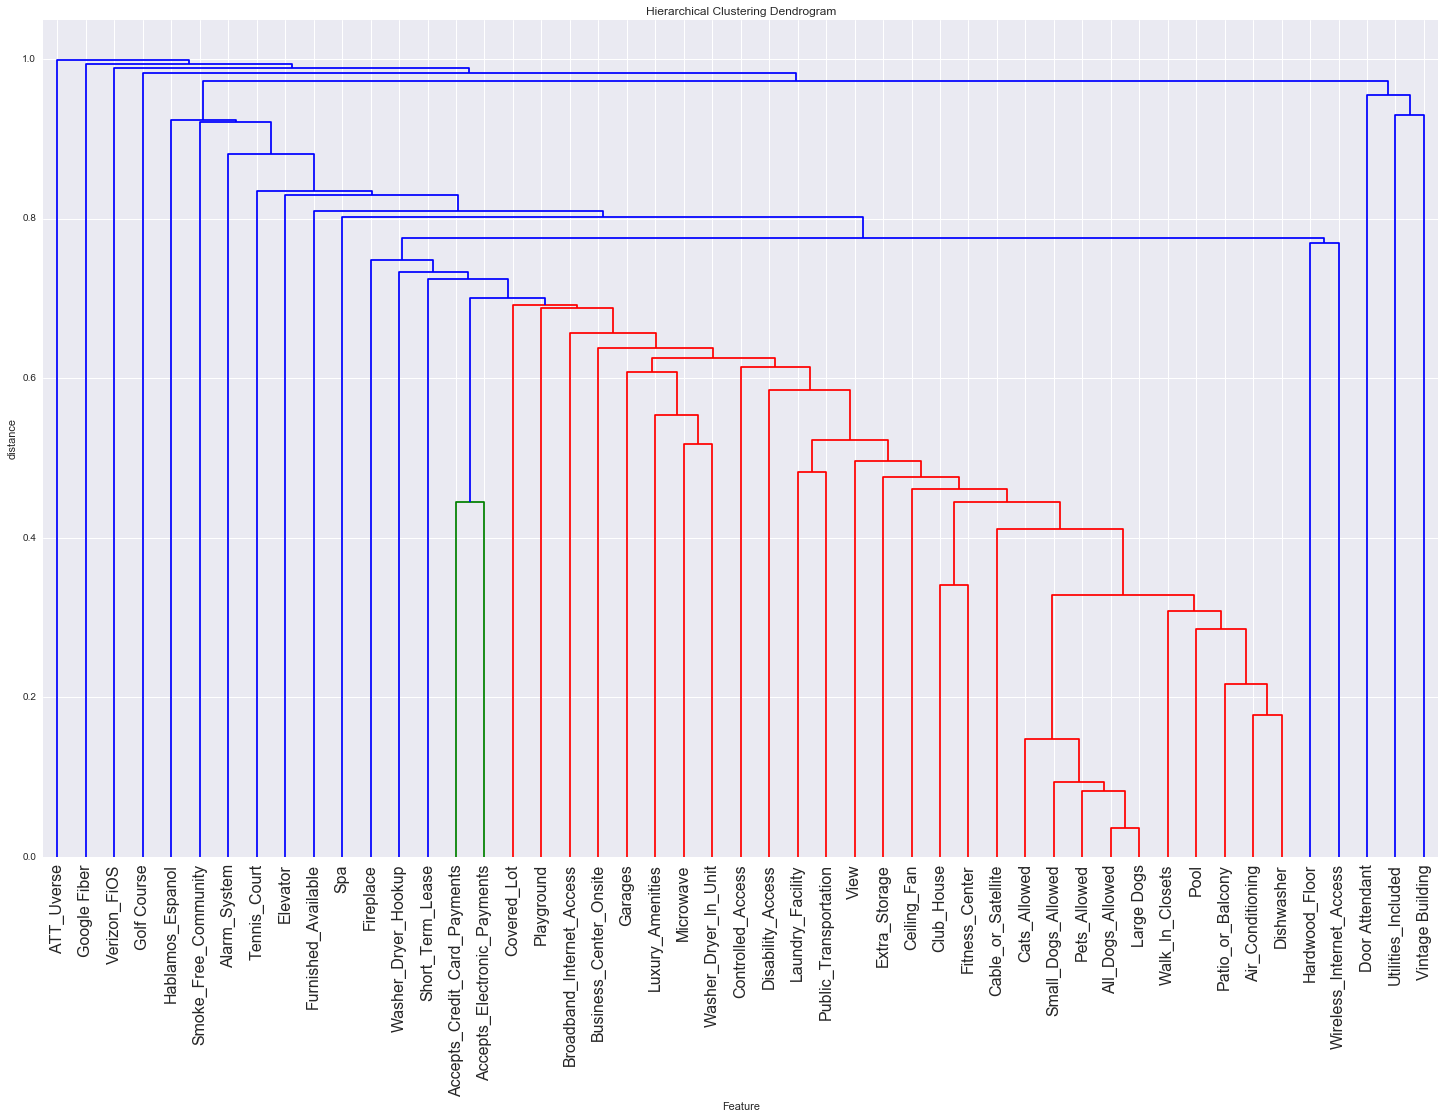

In [15]:
# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('distance')
hierarchy.dendrogram(
    clustering,
    labels = features,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
)
plt.show()

Now we cluster with the weighted average of the distance

https://en.wikipedia.org/wiki/WPGMA

In [16]:
weighted_clustering = hierarchy.linkage(jac_sqrfrm, method = 'weighted')

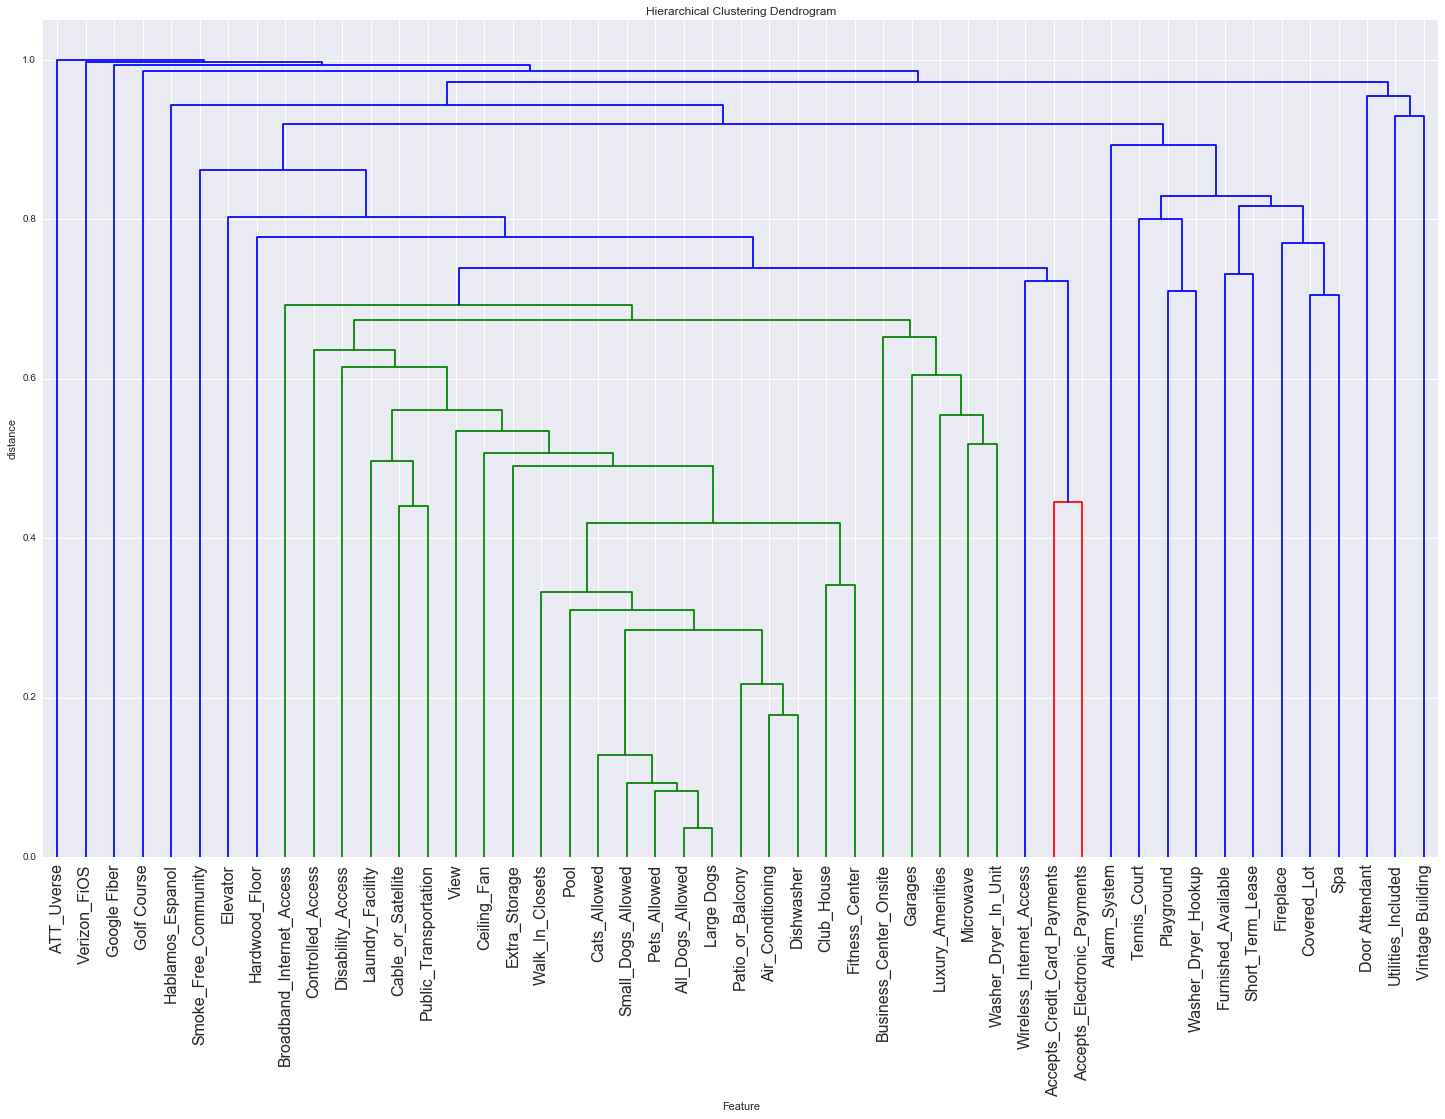

In [17]:
# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('distance')
hierarchy.dendrogram(
    weighted_clustering,
    color_threshold = 0.7,
    labels = features,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
)
plt.show()

### Trying to use dice distance metric instead of jaccard, gives more weight to the intersection of the two sets


some small differences between the two

In [18]:
# generate the linkage matrix
dice_matr = dice_scipy(fa_x)

# # compresses the 2-dimensional square matrix into a
# # 1-dimensional vector storing only the upper diagonal of the matrix - its symmetric along the diagonal so its chill
dice_sqrfrm = squareform(dice_matr)

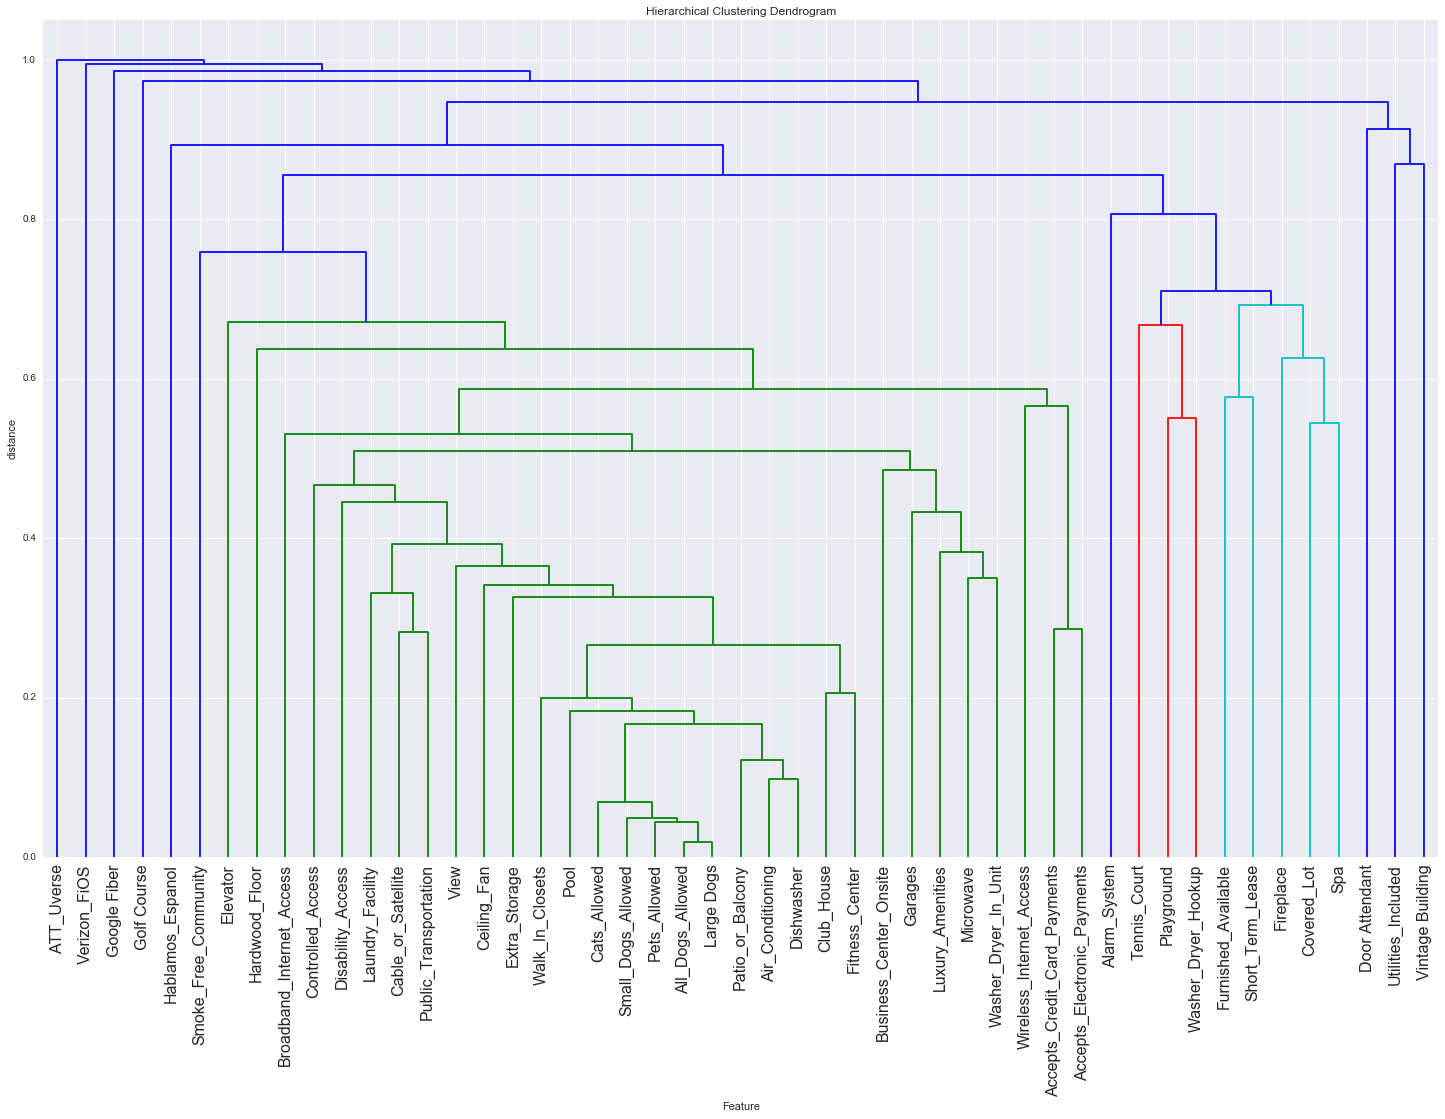

In [19]:
dice_clustering = hierarchy.linkage(dice_sqrfrm, method = 'weighted')

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('distance')
hierarchy.dendrogram(
    dice_clustering,
    color_threshold = 0.7,
    labels = features,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
)
plt.show()

# Ward with Dice and Jaccard

using Ward's clustering algorithm and dice and jaccard distance matrices we cluster the amenities

1. First we do wards with jaccard similarity
2. Then try it with dice similarity

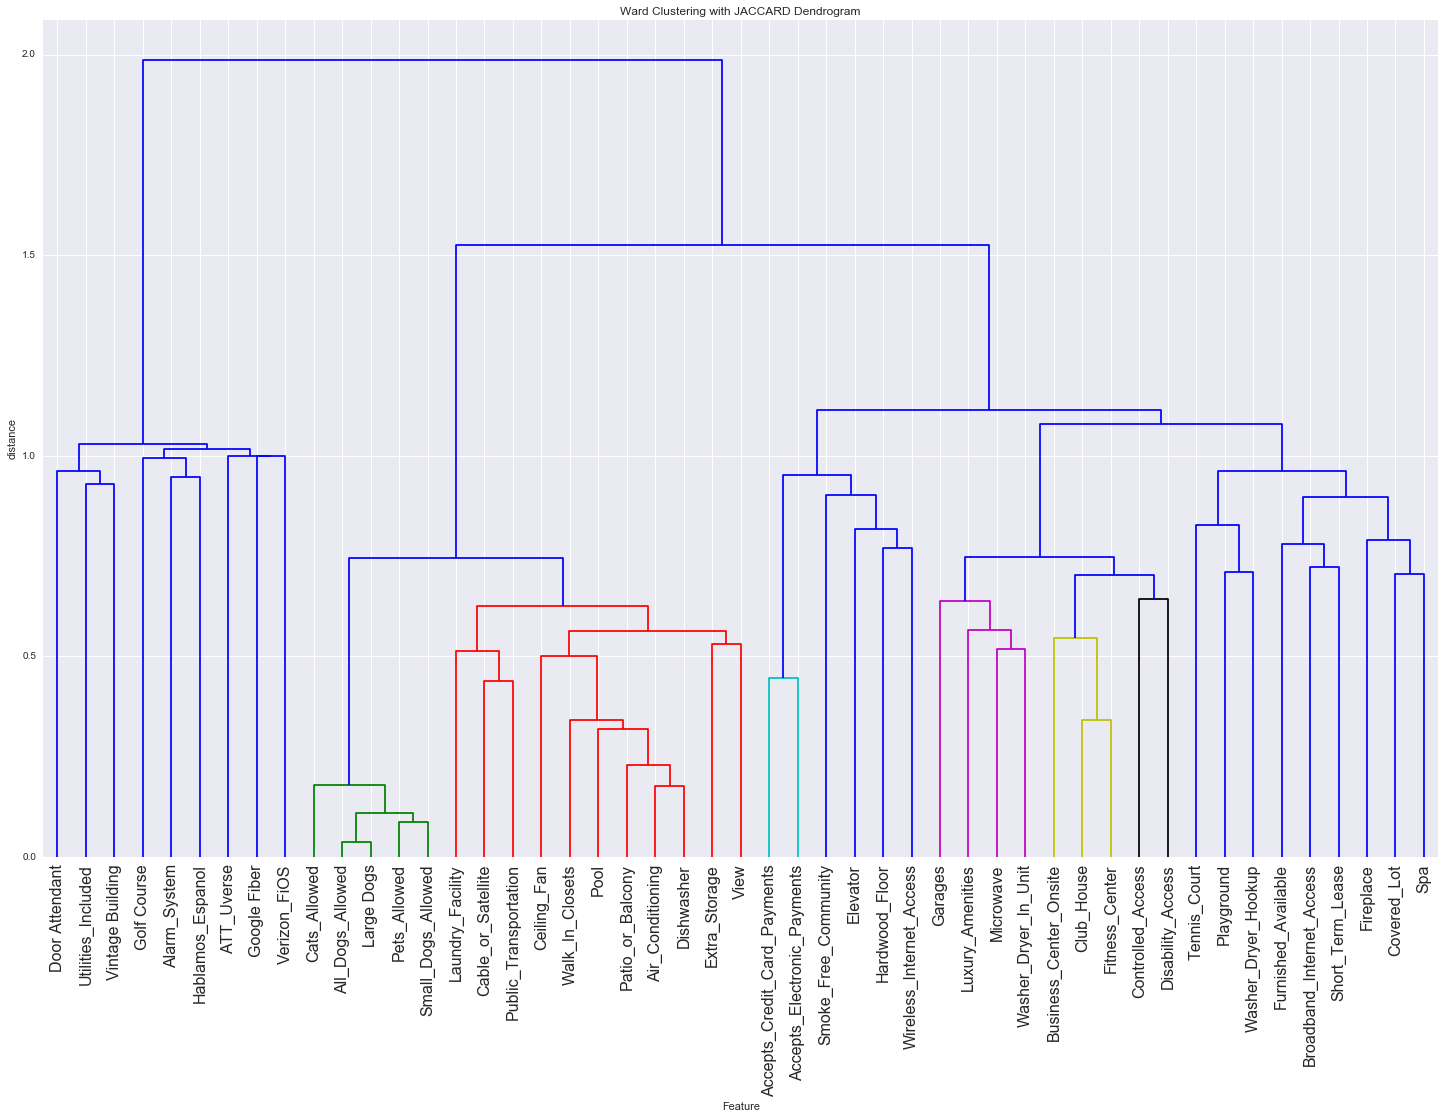

In [54]:
#jaccard
jac_ward = fastcluster.ward(jac_sqrfrm)

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Ward Clustering with JACCARD Dendrogram')
plt.xlabel('Feature')
plt.ylabel('distance')
hierarchy.dendrogram(
    jac_ward,
    color_threshold = 0.7,
    labels = features,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
)
plt.show()

In [100]:
print "Groupings for Ward with Jaccard, cutoff disance of 1:\n "
get_flattened(jac_ward, cutoff = 1, criter = 'distance', feature_list= features)

Groupings for Ward with Jaccard, cutoff disance of 1
 
Group 1:  ['Door Attendant', 'Utilities_Included', 'Vintage Building']

Group 2:  ['Alarm_System', 'Golf Course', 'Hablamos_Espanol']

Group 3:  ['Google Fiber', 'Verizon_FiOS', 'ATT_Uverse']

Group 4:  ['Air_Conditioning', 'All_Dogs_Allowed', 'Cable_or_Satellite', 'Cats_Allowed', 'Ceiling_Fan', 'Dishwasher', 'Extra_Storage', 'Large Dogs', 'Laundry_Facility', 'Patio_or_Balcony', 'Pets_Allowed', 'Pool', 'Public_Transportation', 'Small_Dogs_Allowed', 'View', 'Walk_In_Closets']

Group 5:  ['Elevator', 'Hardwood_Floor', 'Accepts_Credit_Card_Payments', 'Accepts_Electronic_Payments', 'Smoke_Free_Community', 'Wireless_Internet_Access']

Group 6:  ['Business_Center_Onsite', 'Club_House', 'Controlled_Access', 'Disability_Access', 'Fitness_Center', 'Garages', 'Microwave', 'Washer_Dryer_In_Unit', 'Luxury_Amenities']

Group 7:  ['Broadband_Internet_Access', 'Covered_Lot', 'Fireplace', 'Furnished_Available', 'Playground', 'Short_Term_Lease', 'S

### Now dice similarity

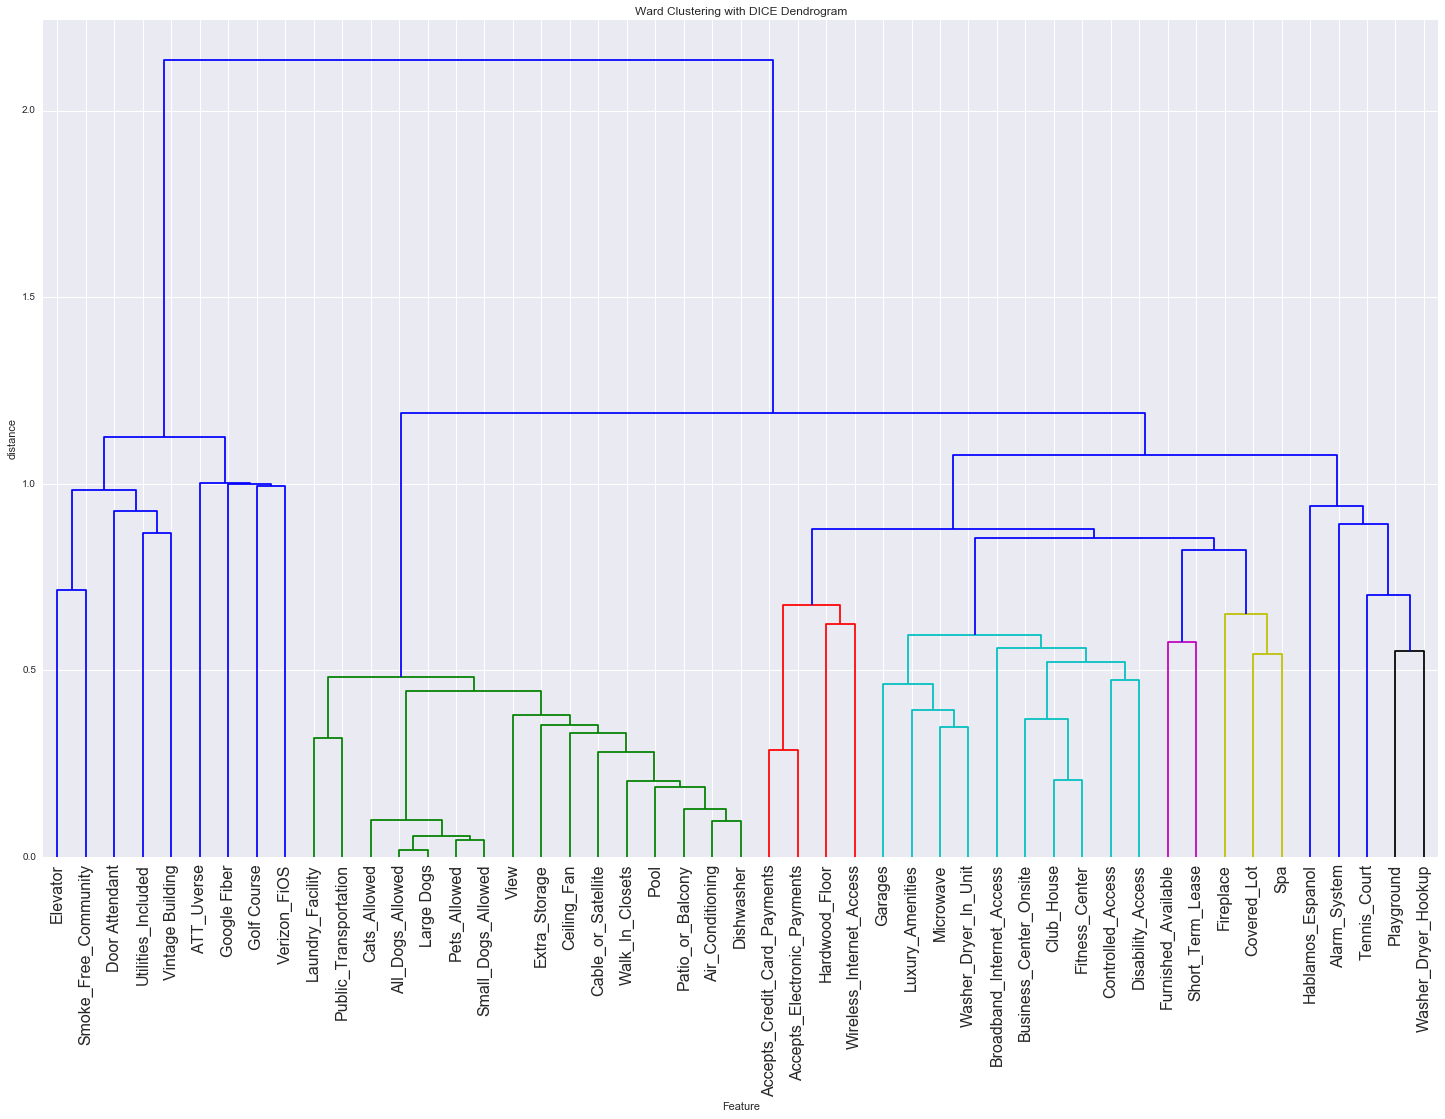

In [55]:
#dice 
dice_ward = fastcluster.ward(dice_sqrfrm)

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Ward Clustering with DICE Dendrogram')
plt.xlabel('Feature')
plt.ylabel('distance')
hierarchy.dendrogram(
    dice_ward,
    color_threshold = 0.7,
    labels = features,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
)
plt.show()

In [103]:
get_flattened(dice_ward, cutoff = .75, criter = 'distance', feature_list= features)

Group 1:  ['Elevator', 'Smoke_Free_Community']

Group 2:  ['Utilities_Included']

Group 3:  ['Vintage Building']

Group 4:  ['Door Attendant']

Group 5:  ['Golf Course']

Group 6:  ['Verizon_FiOS']

Group 7:  ['Google Fiber']

Group 8:  ['ATT_Uverse']

Group 9:  ['Air_Conditioning', 'All_Dogs_Allowed', 'Cable_or_Satellite', 'Cats_Allowed', 'Ceiling_Fan', 'Dishwasher', 'Extra_Storage', 'Large Dogs', 'Laundry_Facility', 'Patio_or_Balcony', 'Pets_Allowed', 'Pool', 'Public_Transportation', 'Small_Dogs_Allowed', 'View', 'Walk_In_Closets']

Group 10:  ['Hardwood_Floor', 'Accepts_Credit_Card_Payments', 'Accepts_Electronic_Payments', 'Wireless_Internet_Access']

Group 11:  ['Broadband_Internet_Access', 'Business_Center_Onsite', 'Club_House', 'Controlled_Access', 'Disability_Access', 'Fitness_Center', 'Garages', 'Microwave', 'Washer_Dryer_In_Unit', 'Luxury_Amenities']

Group 12:  ['Furnished_Available', 'Short_Term_Lease']

Group 13:  ['Covered_Lot', 'Fireplace', 'Spa']

Group 14:  ['Playground

### Drop really popular and unpopular amenities (from top 10 and bottom 10)

Try to eliminate some interactions due to popularity

In [22]:
#removed patio, cats, dishwasher Air conditioning, att uverse, google fiber, golf course, door attendent, verizon
mod_features = ['Alarm_System', 'All_Dogs_Allowed',
    'Broadband_Internet_Access','Business_Center_Onsite', 
    'Cable_or_Satellite', 'Ceiling_Fan',
    'Club_House', 'Controlled_Access', 'Covered_Lot',
    'Disability_Access',  
    'Elevator','Extra_Storage', 'Fireplace', 'Fitness_Center',
    'Furnished_Available', 'Garages',  
    'Hablamos_Espanol', 'Hardwood_Floor', 'Large Dogs',
    'Laundry_Facility', 'Microwave',  'Pets_Allowed',
    'Playground', 'Pool', 'Public_Transportation', 'Short_Term_Lease',
    'Small_Dogs_Allowed', 'Spa', 'Tennis_Court', 'Utilities_Included',
    'View', 'Vintage Building', 'Walk_In_Closets',
    'Washer_Dryer_Hookup', 'Washer_Dryer_In_Unit',
    'Accepts_Credit_Card_Payments', 'Accepts_Electronic_Payments',
    'Luxury_Amenities', 'Smoke_Free_Community',
    'Wireless_Internet_Access']

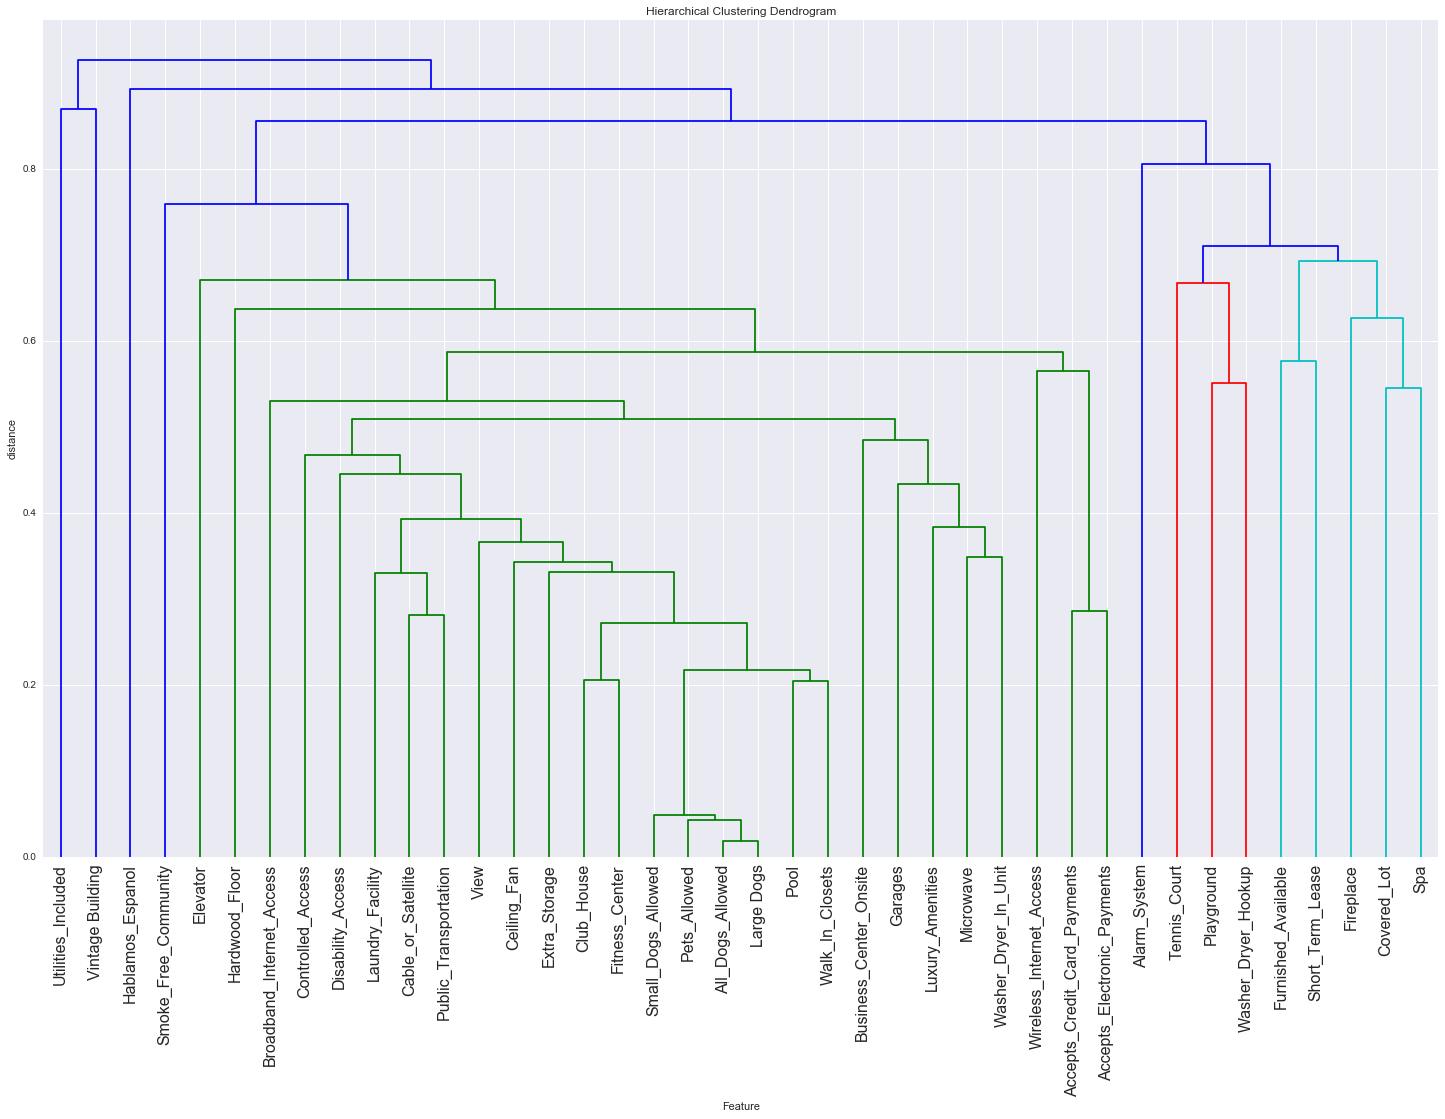

In [23]:
mod_x = fa_x[mod_features]

# generate the linkage matrix
mod_dice_matr = dice_scipy(mod_x)

# compresses the 2-dimensional square matrix into a
# 1-dimensional vector storing only the upper diagonal of the matrix - its symmetric along the diagonal so its chill
mod_dice_sqrfrm = squareform(mod_dice_matr)

mod_dice_clustering = hierarchy.linkage(mod_dice_sqrfrm, method = 'weighted')

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('distance')
hierarchy.dendrogram(
    mod_dice_clustering,
    color_threshold = 0.7,
    labels = mod_features,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
)
plt.show()

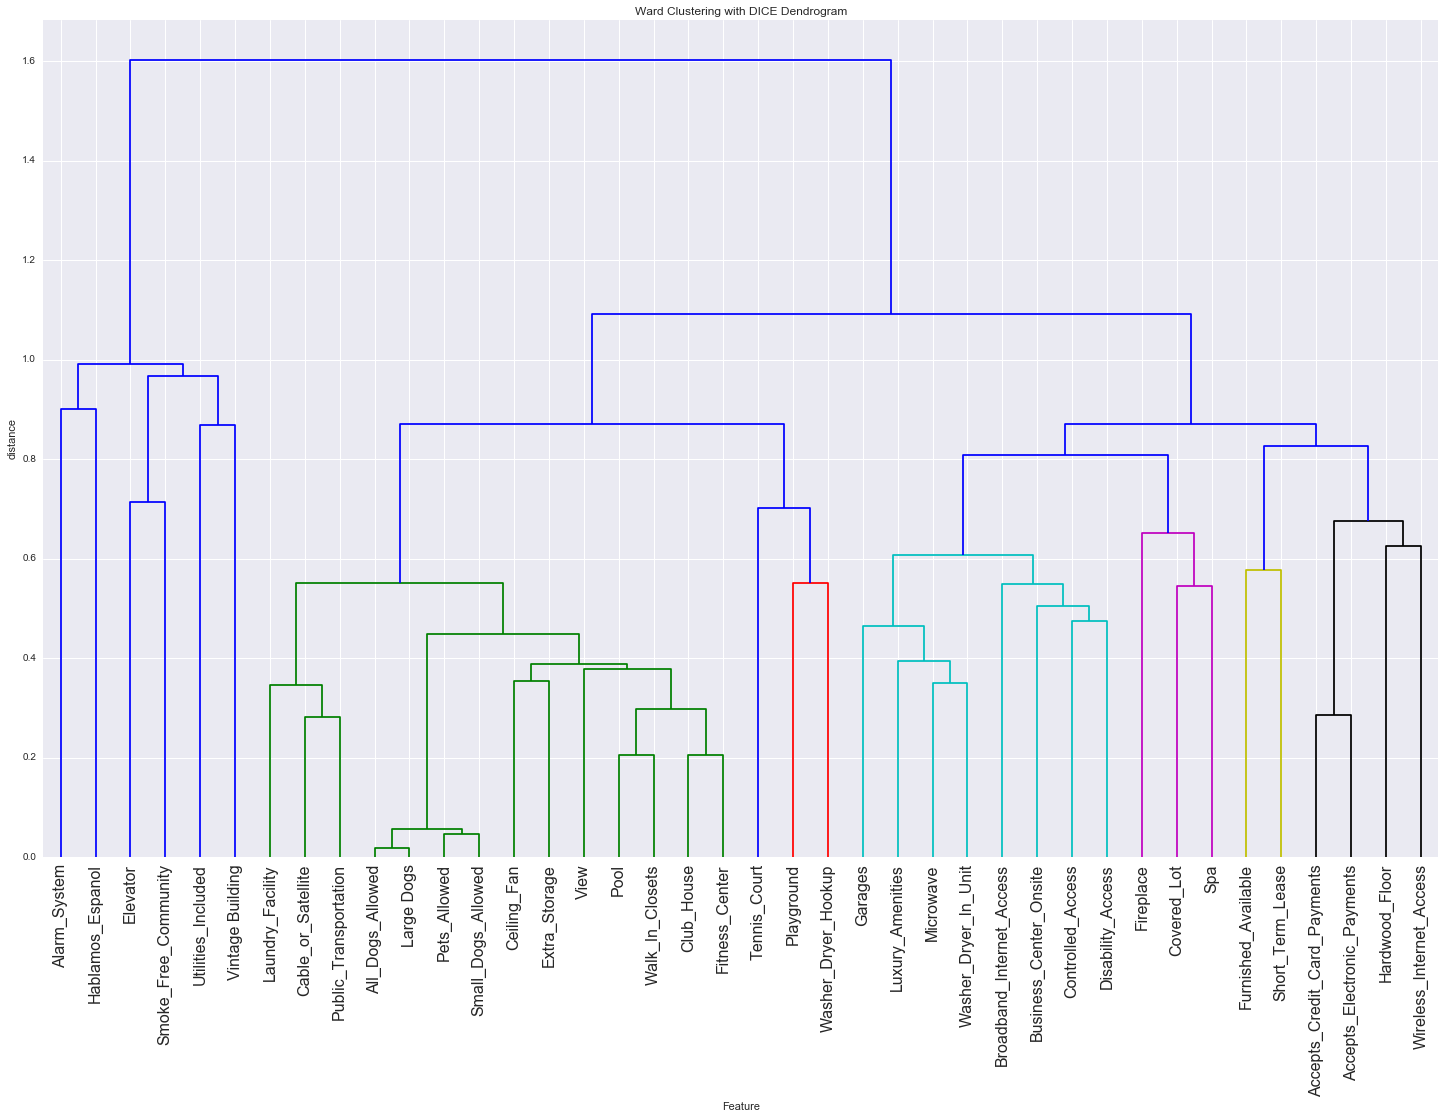

In [83]:
mod_dice_ward = fastcluster.ward(mod_dice_sqrfrm)

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Ward Clustering with DICE Dendrogram')
plt.xlabel('Feature')
plt.ylabel('distance')
hierarchy.dendrogram(
    mod_dice_ward,
    color_threshold = 0.7,
    labels = mod_features,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
)
plt.show()

# Conclusion

The amenities form mostly intuitive groups, however they are heavily affected by their frequency within the dataset. Continued work will be done to help account for this bias.